In [5]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import torch

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

FEATURES = ["delay_seconds_calc", "hour", "weekday"]
TARGET   = "y_end_delay_calc"
STOP_COL = "last_stop_id"

BASELINE_DIR = "../data/baselines/"
MODEL_DIR    = "../data/models/"
DATA_PATH    = "../data/processed_dataset.csv"

In [6]:
df = pd.read_csv(DATA_PATH, parse_dates=["vehicle_timestamp"])
df = df.sort_values("vehicle_timestamp")

for c in FEATURES + [TARGET]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df[FEATURES] = df[FEATURES].fillna(0.0)
df = df.dropna(subset=[TARGET, STOP_COL]).copy()

TRAIN_END = df["vehicle_timestamp"].quantile(0.70)
VAL_END   = df["vehicle_timestamp"].quantile(0.85)

train_df = df[df["vehicle_timestamp"] < TRAIN_END].copy()
val_df   = df[(df["vehicle_timestamp"] >= TRAIN_END) & (df["vehicle_timestamp"] < VAL_END)].copy()
test_df  = df[df["vehicle_timestamp"] >= VAL_END].copy()

print("rows:", len(df))
print("min/max:", df["vehicle_timestamp"].min(), df["vehicle_timestamp"].max())
print("TRAIN_END:", TRAIN_END)
print("VAL_END:", VAL_END)
print("train/val/test:", len(train_df), len(val_df), len(test_df))


/tmp/ipykernel_57619/609258936.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH, parse_dates=["vehicle_timestamp"])


rows: 6170467
min/max: 2025-11-10 03:16:27 2025-11-24 23:15:24
TRAIN_END: 2025-11-21 09:07:14
VAL_END: 2025-11-23 07:37:33
train/val/test: 4319310 925566 925591


# basic baselines

In [15]:
def eval_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(mean_squared_error(y_true, y_pred, squared=False)),
    }


In [16]:
base_res = pd.read_csv(BASELINE_DIR + "baseline_results.csv")
base_res = base_res.rename(columns={"MAE_seconds": "mae", "RMSE_seconds": "rmse"})
base_res

,model,model_type,mae,rmse
0,baseline_mean,statistical,169.795792,314.882324
1,baseline_current_delay,heuristic,182.828293,387.024780
2,linear_regression,linear,157.909032,286.226798


# LR

In [18]:
lr = joblib.load(BASELINE_DIR + "linear_regression.joblib")
lr_x_scaler = joblib.load(BASELINE_DIR + "linear_regression_scaler.joblib")


X = test_df[FEATURES].values
Xs = lr_x_scaler.transform(X)

# predikció már eredeti skálán
pred_lr = lr.predict(Xs)

lr_row = {
    "model": "LinearRegression",
    "mae": float(mean_absolute_error(test_df[TARGET].values, pred_lr)),
    "rmse": float(mean_squared_error(test_df[TARGET].values, pred_lr, squared=False)),
}
print("LR test results:", lr_row)

LR test results: {'model': 'LinearRegression', 'mae': 157.90903166053425, 'rmse': 286.2267978545924}


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# gnn

In [27]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

import joblib
from tqdm.auto import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.loader import DataLoader as PyGDataLoader

DATA_PATH      = "../data/processed_dataset.csv"
STOP_TIMES     = "../data/stop_times.txt"
CKPT_PATH      = "../data/models/gnn_sage_k2.pt"
XSCALER_PATH   = "../data/baselines/gnn_x_scaler.joblib"
YSCALER_PATH   = "../data/baselines/gnn_y_scaler.joblib"
BASELINE_CSV   = "../data/baselines/baseline_results.csv"
OUT_DIR        = "../output"

In [28]:
FEATURES = ["delay_seconds_calc", "hour", "weekday"]
TARGET   = "y_end_delay_calc"
STOP_COL = "last_stop_id"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(OUT_DIR, exist_ok=True)

In [29]:
df = pd.read_csv(DATA_PATH, parse_dates=["vehicle_timestamp"])
df = df.sort_values("vehicle_timestamp")

for c in FEATURES + [TARGET]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df[FEATURES] = df[FEATURES].fillna(0.0)
df = df.dropna(subset=[TARGET, STOP_COL]).copy()

TRAIN_END = df["vehicle_timestamp"].quantile(0.70)
VAL_END   = df["vehicle_timestamp"].quantile(0.85)

test_df  = df[df["vehicle_timestamp"] >= VAL_END].copy()

print("rows:", len(df))
print("min/max:", df["vehicle_timestamp"].min(), df["vehicle_timestamp"].max())
print("train/val/test:", len(df[df["vehicle_timestamp"] < TRAIN_END]),
      len(df[(df["vehicle_timestamp"] >= TRAIN_END) & (df["vehicle_timestamp"] < VAL_END)]),
      len(test_df))

/tmp/ipykernel_57619/2492822574.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH, parse_dates=["vehicle_timestamp"])


rows: 6170467
min/max: 2025-11-10 03:16:27 2025-11-24 23:15:24
train/val/test: 4319310 925566 925591


In [30]:
stop_times = pd.read_csv(STOP_TIMES)
stop_times["stop_sequence"] = pd.to_numeric(stop_times["stop_sequence"], errors="coerce")
stop_times = stop_times.dropna(subset=["trip_id", "stop_id", "stop_sequence"]).copy()
stop_times["stop_id"] = stop_times["stop_id"].astype(str)

all_stops = stop_times["stop_id"].unique()
stop2idx = {s: i for i, s in enumerate(all_stops)}
num_nodes = len(stop2idx)

edges = set()
for trip_id, g in stop_times.groupby("trip_id"):
    g = g.sort_values("stop_sequence")
    stops = g["stop_id"].values
    for i in range(len(stops) - 1):
        u = stop2idx.get(stops[i])
        v = stop2idx.get(stops[i + 1])
        if u is not None and v is not None and u != v:
            edges.add((u, v))
            edges.add((v, u))

edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous().to(DEVICE)
print("num_nodes:", num_nodes, "num_edges:", edge_index.size(1))

/tmp/ipykernel_57619/1304807634.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  stop_times = pd.read_csv(STOP_TIMES)


num_nodes: 5545 num_edges: 13652


In [31]:
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
K = int(ckpt.get("k_hop", 2))

subgraph_cache = {}
for s, nid in stop2idx.items():
    subset, sub_edge_index, mapping, _ = k_hop_subgraph(
        nid, K, edge_index, relabel_nodes=True
    )
    subgraph_cache[nid] = (subset, sub_edge_index, int(mapping.item()))
print("cached subgraphs:", len(subgraph_cache), "K:", K)

cached subgraphs: 5545 K: 2


In [32]:
x_scaler = joblib.load(XSCALER_PATH)
y_scaler = joblib.load(YSCALER_PATH)

In [33]:
def to_node_id(arr):
    return pd.Series(arr).astype(str).map(stop2idx).values

def build_arrays(d):
    node_ids = to_node_id(d[STOP_COL].values)
    mask = ~pd.isna(node_ids)
    node_ids = node_ids[mask].astype(np.int64)

    X = d.loc[mask, FEATURES].values.astype(np.float32)
    y = d.loc[mask, TARGET].values.astype(np.float32)

    Xs = x_scaler.transform(X).astype(np.float32)
    ys = y_scaler.transform(y.reshape(-1, 1)).ravel().astype(np.float32)
    return node_ids, Xs, ys, y, mask

test_node, test_Xs, test_ys, test_yraw, test_mask = build_arrays(test_df)
print("test samples:", len(test_node), " (dropped rows without stop mapping:", int((~test_mask).sum()), ")")

test samples: 925591  (dropped rows without stop mapping: 0 )


In [34]:
class RowGNNDataset(torch.utils.data.Dataset):
    def __init__(self, node_ids, Xs, ys, cache):
        self.node_ids = node_ids
        self.Xs = Xs
        self.ys = ys
        self.cache = cache
        self.in_dim = Xs.shape[1] + 1

    def __len__(self):
        return len(self.node_ids)

    def __getitem__(self, i):
        nid = int(self.node_ids[i])
        feats = torch.tensor(self.Xs[i], dtype=torch.float32)
        y = torch.tensor(self.ys[i], dtype=torch.float32)

        subset, sub_edge_index, center = self.cache[nid]
        x = torch.zeros((subset.numel(), self.in_dim), dtype=torch.float32)
        x[center, :-1] = feats
        x[center, -1] = 1.0

        return Data(x=x, edge_index=sub_edge_index.cpu(), y=y)

test_ds = RowGNNDataset(test_node, test_Xs, test_ys, subgraph_cache)
test_loader = PyGDataLoader(test_ds, batch_size=512, shuffle=False, num_workers=0)


In [35]:
class SimpleSAGE(nn.Module):
    def __init__(self, in_dim, hidden=64):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.lin = nn.Linear(hidden, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        g = global_mean_pool(x, batch)
        return self.lin(g).squeeze(-1)

model = SimpleSAGE(in_dim=ckpt["in_dim"], hidden=int(ckpt.get("hidden", 64))).to(DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

SimpleSAGE(
  (conv1): SAGEConv(4, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
preds_s = []
ys_s = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="GNN test inference"):
        batch = batch.to(DEVICE)
        pred = model(batch).detach().cpu().numpy()
        preds_s.append(pred)
        ys_s.append(batch.y.detach().cpu().numpy())

preds_s = np.concatenate(preds_s)
ys_s    = np.concatenate(ys_s)

preds = y_scaler.inverse_transform(preds_s.reshape(-1, 1)).ravel()
ys    = y_scaler.inverse_transform(ys_s.reshape(-1, 1)).ravel()

gnn_mae  = float(mean_absolute_error(ys, preds))
gnn_rmse = float(mean_squared_error(ys, preds, squared=False))

print("GNN TEST MAE (sec):", gnn_mae)
print("GNN TEST RMSE (sec):", gnn_rmse)

GNN test inference: 100%|██████████| 1808/1808 [02:46<00:00, 10.89it/s]

GNN TEST MAE (sec): 131.45504760742188
GNN TEST RMSE (sec): 234.52896118164062



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [37]:
filtered_test = test_df.loc[test_mask].copy().reset_index(drop=True)

pred_out = os.path.join(OUT_DIR, "predictions_test_gnn.csv")
out_pred = filtered_test[["vehicle_timestamp", STOP_COL, TARGET]].copy()
out_pred["pred_gnn"] = preds
out_pred.to_csv(pred_out, index=False)
print("Saved:", pred_out)


Saved: ../output/predictions_test_gnn.csv


In [40]:
gnn_rmse = rmse
gnn_mae  = mae

In [41]:
base_res = pd.read_csv(BASELINE_DIR + "baseline_results.csv")
base_res = base_res.rename(columns={"MAE_seconds": "mae", "RMSE_seconds": "rmse"})

# biztosítsuk a szükséges oszlopokat
need_cols = {"model", "model_type", "mae", "rmse"}
missing = need_cols - set(base_res.columns)
if missing:
    raise ValueError(f"baseline_results.csv hiányzó oszlopok: {missing}")

gnn_row = pd.DataFrame([{
    "model": f"gnn_sage_k{int(ckpt.get('k_hop', 2))}",
    "model_type": "gnn",
    "mae": gnn_mae,
    "rmse": gnn_rmse
}])

all_res = pd.concat([base_res[["model", "model_type", "mae", "rmse"]], gnn_row], ignore_index=True)
all_res = all_res.sort_values("mae").reset_index(drop=True)

out_metrics = os.path.join(OUT_DIR, "eval_metrics_all.csv")
all_res.to_csv(out_metrics, index=False)
print("Saved:", out_metrics)

Saved: ../output/eval_metrics_all.csv


In [42]:
print(all_res)

                    model   model_type         mae        rmse
0             gnn_sage_k2          gnn  131.455048  234.528961
1       linear_regression       linear  157.909032  286.226798
2           baseline_mean  statistical  169.795792  314.882324
3  baseline_current_delay    heuristic  182.828293  387.024780


In [45]:
THRESHOLD = 120.0

# abszolút hiba másodpercben
abs_error = np.abs(preds - ys)

# helyes találat: |pred - true| <= 60 sec
correct = abs_error <= THRESHOLD

accuracy_60 = correct.mean()

print(f"GNN Accuracy @ {int(THRESHOLD)}s: {accuracy_60:.4f} ({accuracy_60*100:.2f}%)")

GNN Accuracy @ 120s: 0.6514 (65.14%)


In [46]:
acc_30  = (np.abs(preds - ys) <= 30).mean()
acc_60  = (np.abs(preds - ys) <= 60).mean()
acc_120 = (np.abs(preds - ys) <= 120).mean()

pd.DataFrame({
    "threshold_sec": [30, 60, 120],
    "accuracy": [acc_30, acc_60, acc_120],
    "accuracy_pct": [acc_30*100, acc_60*100, acc_120*100],
})


,threshold_sec,accuracy,accuracy_pct
0,30,0.203800,20.379952
1,60,0.385275,38.527492
2,120,0.651382,65.138166


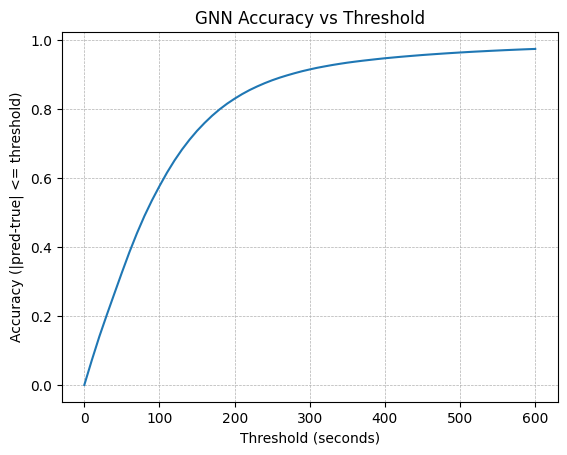

Saved: ../output/gnn_accuracy_vs_threshold.csv


,threshold_sec,accuracy,accuracy_pct
0,0,0.000001,0.000108
1,10,0.071899,7.189893
2,20,0.140513,14.051347
3,30,0.203800,20.379952
4,40,0.265238,26.523810


In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preds, ys: numpy array, seconds (inverse scaled)
assert "preds" in globals() and "ys" in globals(), "Előbb legyen meg a preds és ys (GNN inference után)."

abs_err = np.abs(np.asarray(preds) - np.asarray(ys))

# Threshold grid (seconds)
thresholds = np.arange(0, 601, 10)  # 0..600 sec, step 10
acc = np.array([(abs_err <= t).mean() for t in thresholds])

# Plot
plt.figure()
plt.plot(thresholds, acc)
plt.xlabel("Threshold (seconds)")
plt.ylabel("Accuracy (|pred-true| <= threshold)")
plt.title("GNN Accuracy vs Threshold")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Optional: save curve to CSV
out_dir = "../output"
os.makedirs(out_dir, exist_ok=True)

curve_df = pd.DataFrame({
    "threshold_sec": thresholds,
    "accuracy": acc,
    "accuracy_pct": acc * 100.0
})
curve_path = os.path.join(out_dir, "gnn_accuracy_vs_threshold.csv")
curve_df.to_csv(curve_path, index=False)
print("Saved:", curve_path)

curve_df.head()
